In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

# Load data

In [2]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

# Train

In [3]:
class RBM(nn.Module):
    def __init__(self,
                 n_vis=784,
                 n_hin=625,
                 k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
    def sample_from_p(self,p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
    def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
    def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_, h_
    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

# Pre-Processing Data

In [4]:
input_data=[]
target_data=[]

for _, (data,target) in enumerate(train_loader):
        data =data.view(-1,784)
        data=data.numpy()
        input_data.append(data)

In [5]:
full_input=np.array(input_data[0])
full_input=torch.Tensor(full_input)

for i in range(1,938):
    intermed=np.array(input_data[i])
    intermed=torch.Tensor(intermed)
    
    full_input=torch.cat((full_input, intermed),0)

In [6]:
full_input


 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
          ...             ⋱             ...          
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
[torch.FloatTensor of size 60000x784]

# Training

In [7]:
rbm = RBM(k=1, n_vis=784)
train_op = optim.SGD(rbm.parameters(),0.1)

In [8]:
batch_size_=64

for epoch in range(8):
    loss_ = []
    reconstruction_error=0
    s=0
    for n in range(0, len(full_input)- batch_size_, batch_size_):
        sample_data=full_input[n:n+batch_size_]
        sample_data=Variable(sample_data)
        #sample_data = sample_data.bernoulli()
        v,v1,h1 = rbm(sample_data)
        
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data[0])
        train_op.zero_grad()
        loss.backward()
        train_op.step()
        reconstruction_error+=torch.mean(torch.abs(v-v1))
        s+=1
    print (' loss: ' + str(reconstruction_error/s))     
    print (np.mean(loss_))

 loss: Variable containing:
1.00000e-02 *
  9.3069
[torch.FloatTensor of size 1]

-6.03708706492
 loss: Variable containing:
1.00000e-02 *
  6.9142
[torch.FloatTensor of size 1]

-4.95887438795
 loss: Variable containing:
1.00000e-02 *
  6.4031
[torch.FloatTensor of size 1]

-3.0794572535
 loss: Variable containing:
1.00000e-02 *
  6.1459
[torch.FloatTensor of size 1]

-1.97402973643
 loss: Variable containing:
1.00000e-02 *
  5.9922
[torch.FloatTensor of size 1]

-1.29119097894
 loss: Variable containing:
1.00000e-02 *
  5.8893
[torch.FloatTensor of size 1]

-0.884801581677
 loss: Variable containing:
1.00000e-02 *
  5.8096
[torch.FloatTensor of size 1]

-0.561821382863
 loss: Variable containing:
1.00000e-02 *
  5.7521
[torch.FloatTensor of size 1]

-0.294036083567


# Create Test Subset

In [37]:
input_data=[]

for _, (data,target) in enumerate(test_loader):
        data =data.view(-1,784)
        data=data.numpy()
        input_data.append(data)

In [38]:
test_set=np.array(input_data[0])
test_set=torch.Tensor(test_set)

for i in range(1,157):
    intermed=np.array(input_data[i])
    intermed=torch.Tensor(intermed)
    
    test_set=torch.cat((test_set, intermed),0)      

In [1]:
len(test_set)

NameError: name 'test_set' is not defined

# Testing

In [40]:
output=[]
target_output=[]

test_loss = 0
s=0
for n in range(0,len(test_set)):
    sample_data=Variable(test_set)
    sample_data = sample_data[n:n+1]

    v,v1,h1 = rbm(sample_data)
    test_loss+=torch.mean(torch.abs(v-v1))
    s+=1
    
    
    output.append(v1)
    target_output.append(v)
    
print (' loss: ' + str(test_loss/s)) 

 loss: Variable containing:
1.00000e-02 *
  5.1492
[torch.FloatTensor of size 1]



# Visualising Results

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

In [79]:
target_pixels_=[]

for n in range(0, 10000):
    target_pixels_n=target_output[n][0].data.numpy()
    target_pixels_.append(target_pixels_n)
    
target_pixels_=np.array(target_pixels_)

t=torch.Tensor(target_pixels_)

t=t[0:32]

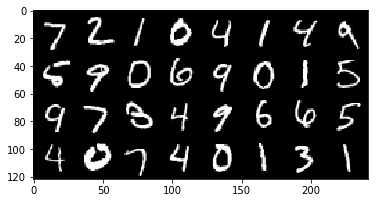

In [85]:
show_adn_save("real",make_grid(t.view(32,1,28,28)))

In [86]:
output_array=[]

for n in range(0, 10000):
    output_n=output[n][0].data.numpy()
    output_array.append(output_n)
    
output_array=np.array(output_array)

n=torch.Tensor(output_array)

n=n[0:32]

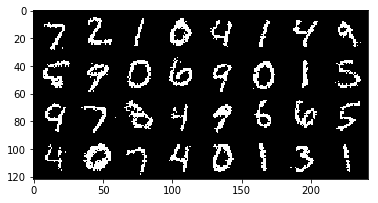

In [87]:
show_adn_save("generated",make_grid(n.view(32,1,28,28)))